<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 3

### <center> Автор материала: Латышев Евгений (@EvgeniyLatyshev)

## <center> Индивидуальный проект по анализу данных </center>
### <center> Прогнозирование уровня производства конфет в США </center>

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 20, 15
import seaborn as sns
from scipy import stats
import pylab
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
from itertools import product
import fbprophet
from tsfresh import extract_features, select_features, extract_relevant_features
from tsfresh.utilities.dataframe_functions import impute, make_forecasting_frame
import xgboost as xgb
from sklearn.metrics import roc_auc_score, mean_absolute_error
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

RANDOM_STATE=42

###  Описание набора данных и признаков

Каждый год люди съедают огромное количество конфет, которое сначала необходимо произвести. Очевидно, что уровень производства постоянно меняется. Например, в канун нового года или на хеллоуин съедается гораздо больше сладостей, чем в другие времена года, что вносит элемент сезонности. Также, в долгосрочной перспективе, уровень производства непреклонно растёт вместе с ростом населения, что говорит об имеющейся трендовой составляющей. Эти свойства делают рассматриваемый показатель отличным подопытным с точки зрения анализа временных рядов.

Датасет, полученный с [Kaggle](https://www.kaggle.com/rtatman/us-candy-production-by-month) содержит данные об уровне производства конфет в США с января 1972 по август 2017 года.

Каждая запись характеризуется двумя значениями:
- observation_date - дата в формате YYYY-MM-DD
- IPG3113N - [индустриальный продуктовый индекс](https://fred.stlouisfed.org/series/INDPRO). Это универсальный индекс уровня производства, который измеряется как % от уровня производста 2012 года.

В данной работе рассматривается задача прогнозирования будущего уровня производства конфет по имеющимся предыдущим наблюдениям. В качестве горизонта прогнозирования выбран временной интервал в 24 месяца.

###  Первичный анализ признаков, визуальный анализ признаков, поиск зависимостей

In [2]:
df = pd.read_csv('../../data/candy_production.csv')

In [3]:
df.head()

,observation_date,IPG3113N
0,1972-01-01,85.6945
1,1972-02-01,71.8200
2,1972-03-01,66.0229
3,1972-04-01,64.5645
4,1972-05-01,65.0100


Сперва приведём данные к более удобному виду.

In [4]:
df.index = pd.to_datetime(df['observation_date'], format='%Y-%m-%d')
df['value'] = df['IPG3113N']
df = df.drop(['observation_date', 'IPG3113N'], axis=1)

In [5]:
df.head()

,value
observation_date,
1972-01-01,85.6945
1972-02-01,71.8200
1972-03-01,66.0229
1972-04-01,64.5645
1972-05-01,65.0100


Теперь проверим данные на наличие пропусков и выбросов.

In [6]:
df.isnull().sum(axis=0)

value    0
dtype: int64

In [7]:
df.describe()

,value
count,548.000000
mean,100.662524
std,18.052931
min,50.668900
25%,87.862475
50%,102.278550
75%,114.691900
max,139.915300


Как видим, датасет содержит 548 значений в промежутке от 50 до 139. Судя по квантилям, данные относительно чистые и не требуют предобработки.

Далее можно выполнить проверку на нормальность и скошенность. Используем критерий Шапиро-Уилка, Q-Q plot и проверку на скошенность из библиотеки scipy.

In [8]:
stats.shapiro(df['value'])

(0.9859577417373657, 3.955519787268713e-05)

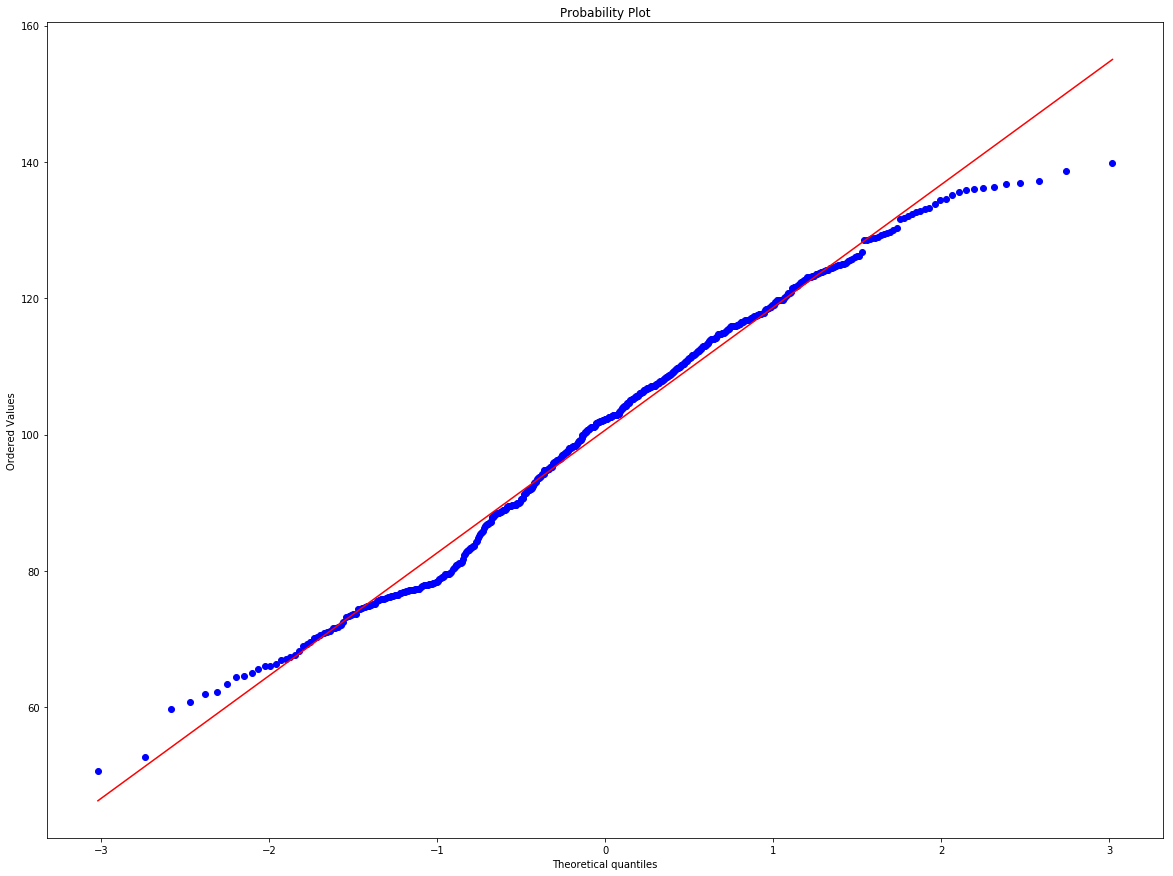

In [9]:
stats.probplot(df['value'], dist="norm", plot=pylab)
pylab.show()

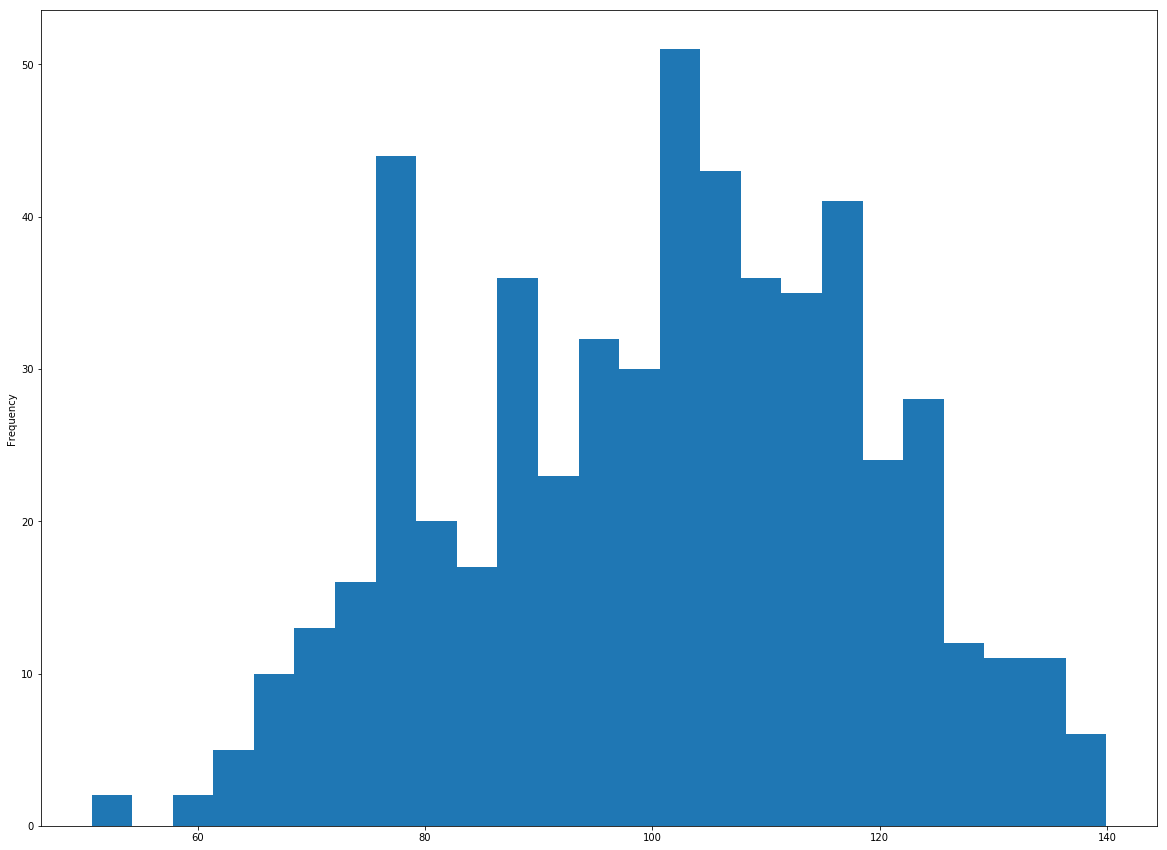

In [10]:
df['value'].plot(kind='hist', bins=25)

In [11]:
stats.skewtest(df['value'])

SkewtestResult(statistic=-1.4413086012614953, pvalue=0.14949751840477085)

Распределение целевой переменной близко к нормальному распределению, но немного скошено.

Пора посмотреть на график самого временного ряда.

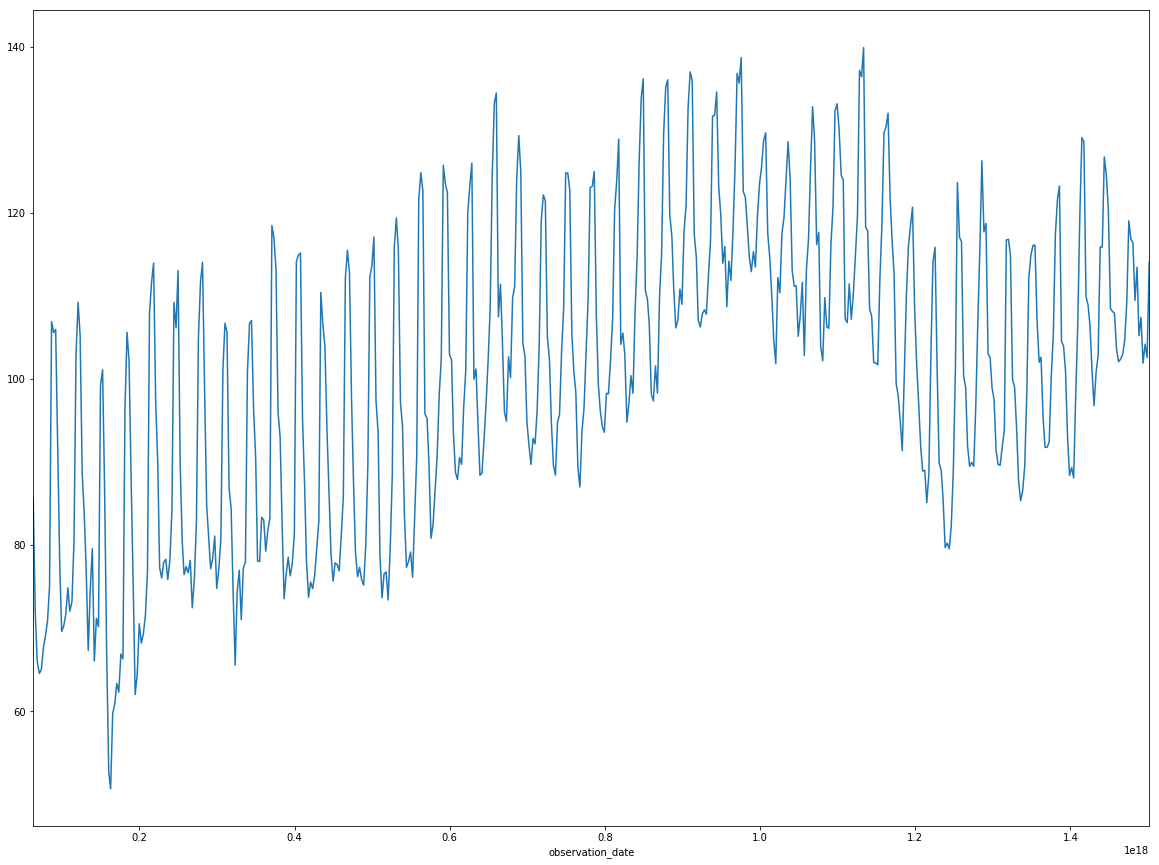

In [12]:
sns.tsplot(data=df['value'], time=df.index)

Посмотрим, что нам даст группировка наблюдений по месяцам и годам.

In [13]:
df['year'] = df.index.year
df['month'] = df.index.month

In [14]:
df.head()

,value,year,month
observation_date,,,
1972-01-01,85.6945,1972,1
1972-02-01,71.8200,1972,2
1972-03-01,66.0229,1972,3
1972-04-01,64.5645,1972,4
1972-05-01,65.0100,1972,5


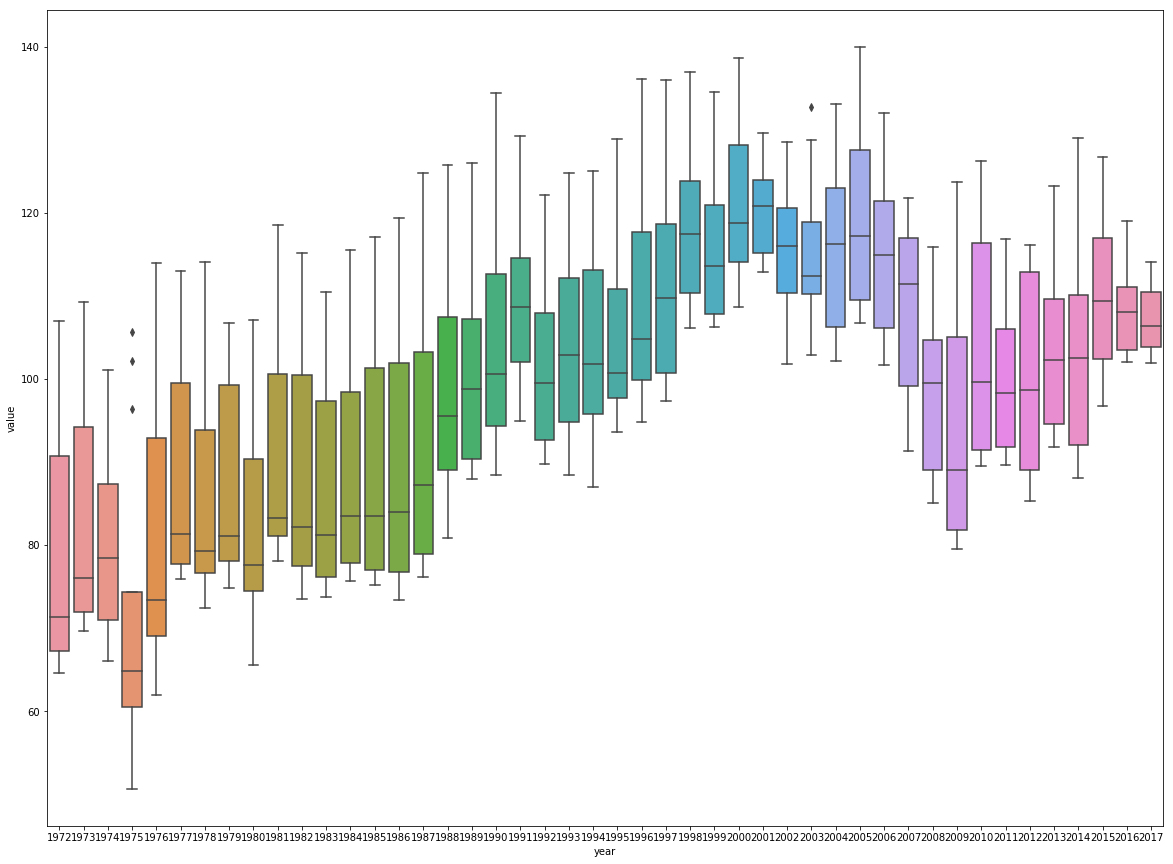

In [15]:
sns.boxplot(x='year', y='value', data=df)

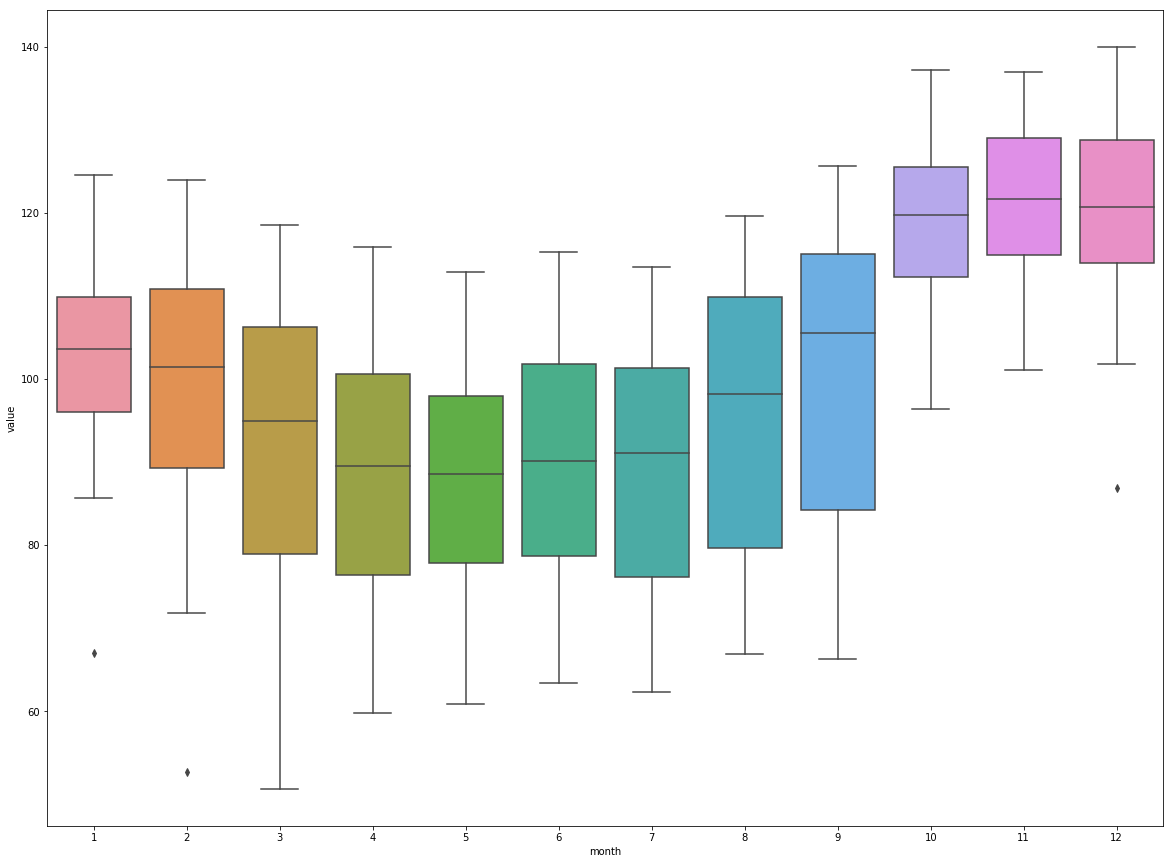

In [16]:
sns.boxplot(x='month', y='value', data=df)

Не считая спада 1975 года, количесво произведённых конфет продолжало уверенно расти вплоть до начала нового тысечелетия, что, возможно связано с ростом населения США, которое за эти годы увеличилось с 210 млн. до 282 млн. Однако, начиная с 2000 года наблюдается некая стагнация, выраженная сравнительно небольшим разбросом производства в эти года, а с 2005 года уровень производства и вовсе начинает падать, что может быть связано с затухающим интересом ко сладкому.

Как и ожидалось, перед хэллоуином и новым годом (октябрь-декабрь) количество производимых сладостей существенно выше, чем в остальные месяцы, что вызвано повышенным спросом. 

###  Выбор метрики

Типичные метрики в задаче регрессии:
- MAE
- RMSE
- MAPE
- SMAPE

Последние 2 метрики позволяют уйти от абсолютных величин к процентам, что является существенным преимуществом, когда целевая переменная меняется в большом диапазоне, как в решаемой задаче. SMAPE, вопреки своему названию, асимметрично штрафует за недопредсказания и перепредсказания, поэтому для оценки модели будем использовать MAPE.

В обсуждениях XGBoost на github разработчики уточнили, что алгоритм плохо сходится при выборе MAPE в качестве метрики, поэтому также будем рассчитывать и MAE для дальнейшего сравнения моделей.

In [17]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

###  Выбор модели

Наиболее часто для предсказания временных рядов используются следующие методы:
- Простейшие модели (наивная, предсказание средним, экспоненциальное сглаживание и т.п.)
- Линейные модели
- Эконометрические модели (ARIMA)
- Facebook Prophet
- XGBoost
- LSTM RNNs

Простейшие модели, как правило, используются как baseline и дают куда менее точные прогнозы, чем остальные методы.

Линейные модели плохо справляются с нелинейными зависимостями и едва ли дадут хороший результат в решаемой задаче. Разве что, можно воспользоваться регрессией с lasso-регуляризагией для отбора признаков на вход другой модели.

Чаще всего, в статьях на arxiv.org рассматриваемая задача решается с помощью LSTM-нейросеток, но мне пока что не хватает навыков в работе с нейросетями, поэтому данный метод также останется за рамками этой работы.

А вот оставшиеся 3 модели можно проверить на имеющихся данных и выбрать ту, которая себя проявит лучше других.

###  Предобработка данных и создание новых признаков

### ARIMA

Сперва подготовим данные для обучения <b>ARIMA</b>-модели. В основе данного подхода лежит предположение о том, что исследуемый временной ряд стационарен. Если это не так, нужно произвести соответсвующие преобразования, чтобы он стал таковым.

Можно провести STL-декомпозицию ряда и проверить остатки на стационарность с помощью критерия Дики-Фуллера.

Критерий Дики-Фуллера: p=0.338178


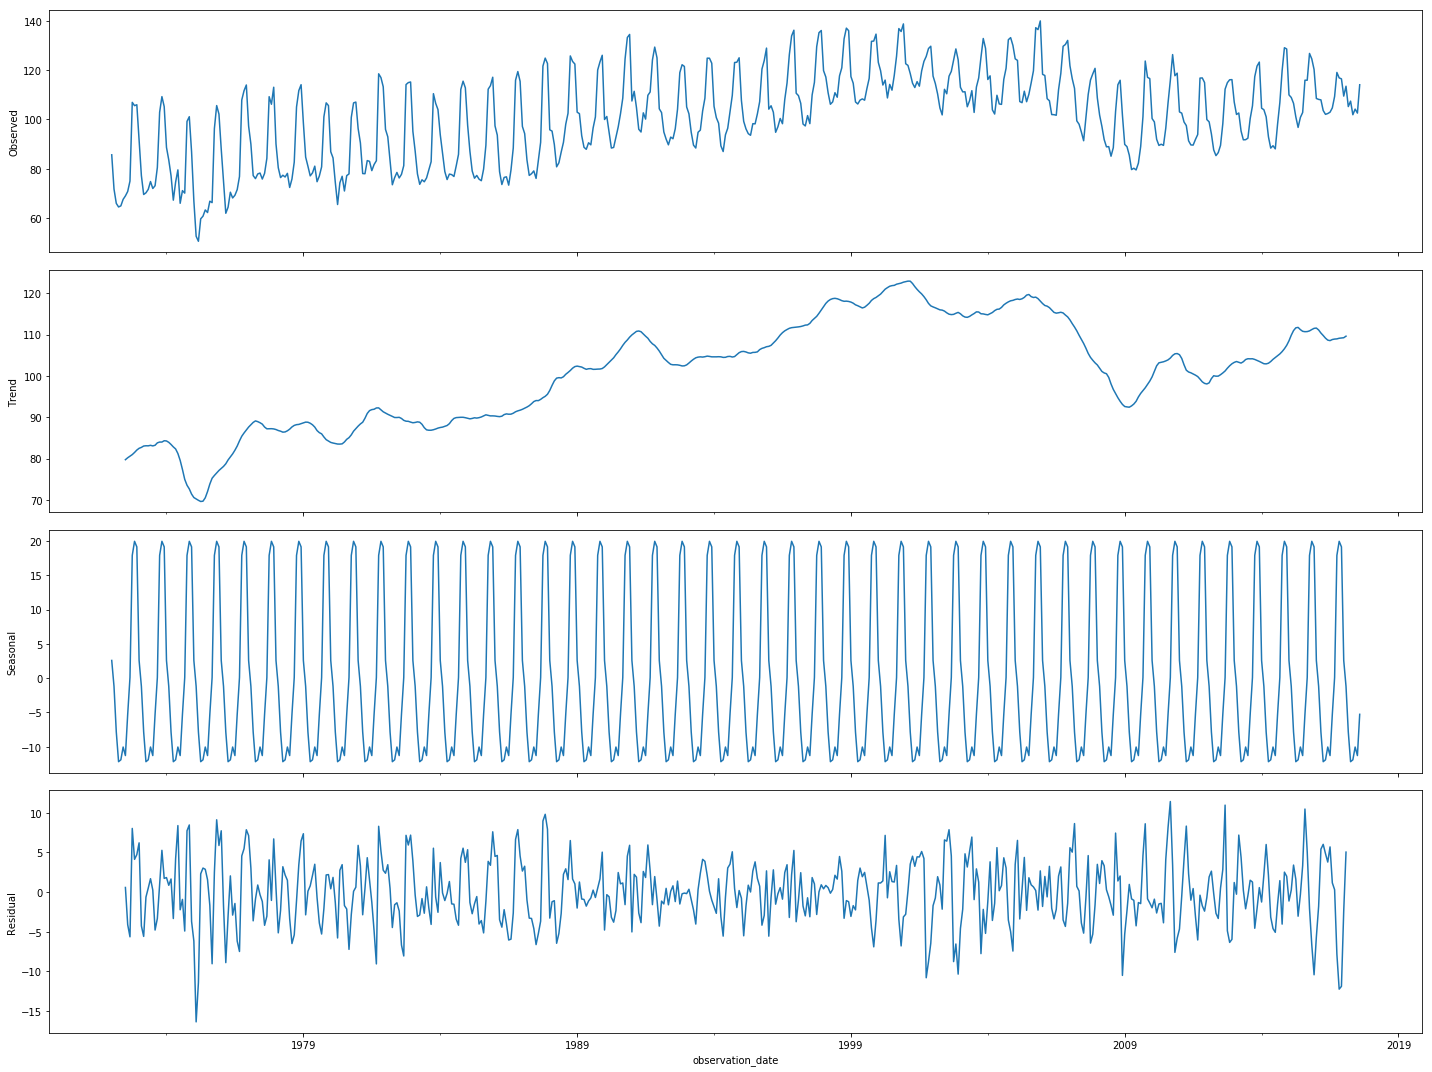

In [18]:
sm.tsa.seasonal_decompose(df['value']).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df['value'])[1])

Критерий Дики-Фуллера отверг гипотезу о стационарности ряда. Следовательно, требуется его дальнейшая обработка.

Продиффериенциируем ряд с лагом 12 (по количеству месяцев).

Критерий Дики-Фуллера: p=0.000023


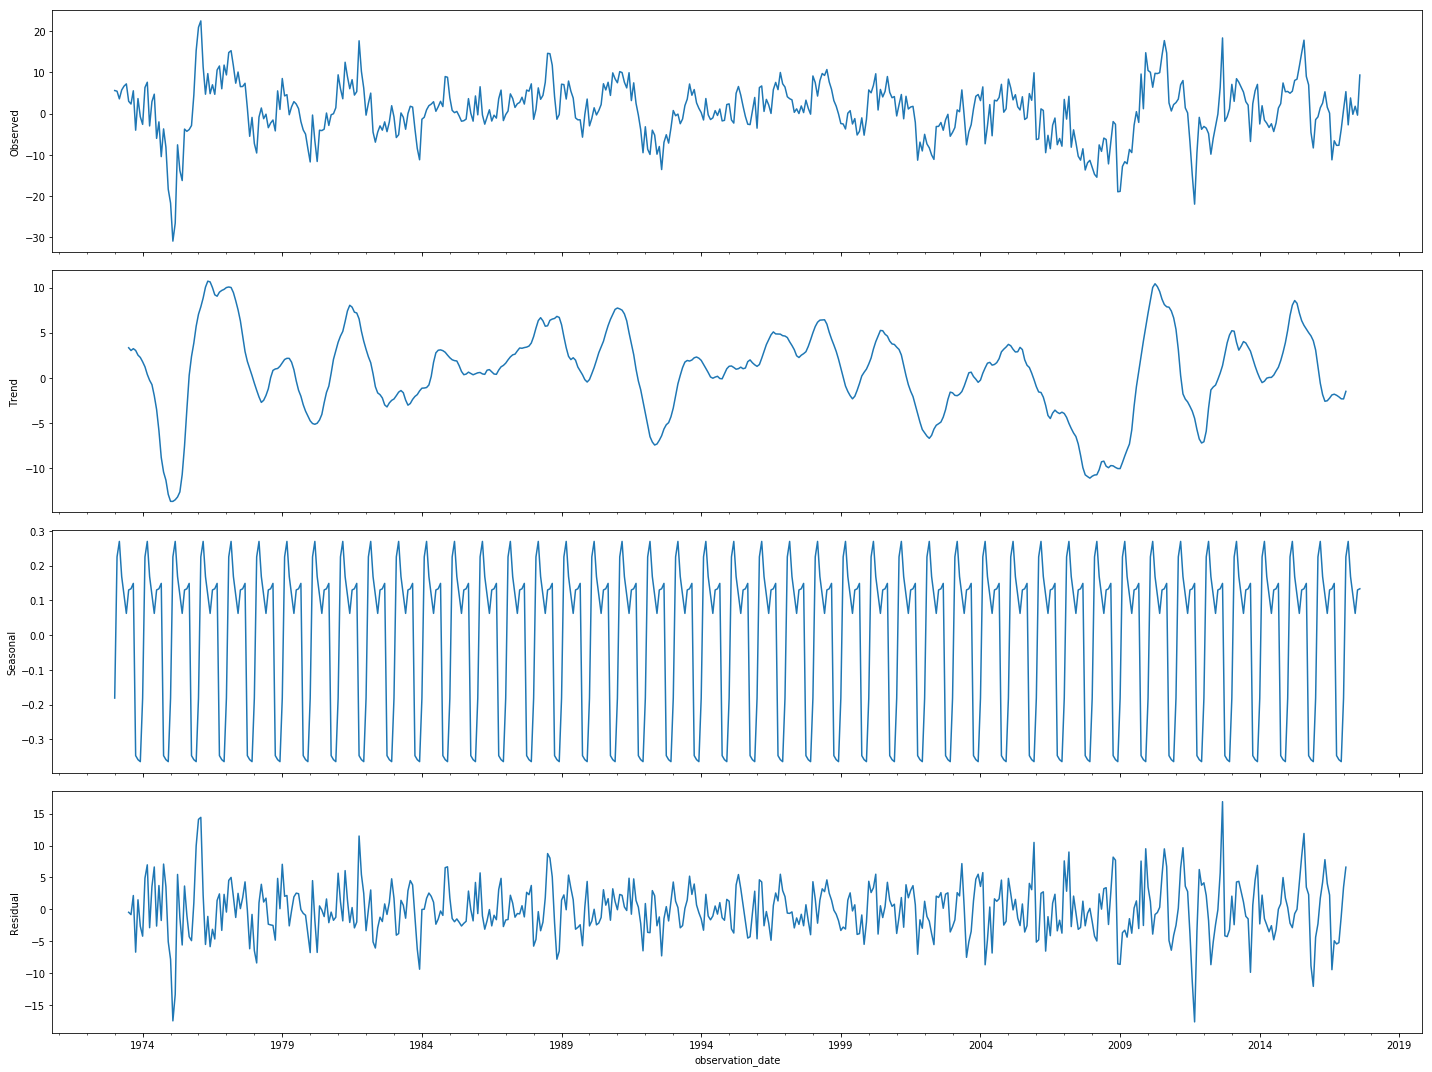

In [19]:
df['value_diff'] = df['value'] - df['value'].shift(12)
sm.tsa.seasonal_decompose(df['value_diff'][12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df['value_diff'][12:])[1])

Остатки стационарны, тренд постоянен, можно подавать его на вход <b>ARIMA</b>.

Отложим 2 года для дальнейшей оценки модели.

In [20]:
df_train = df[:-24]
df_test = df[-24:]

### Facebook Prophet

Главное преимущество <b>Facebook Prophet</b> - простота использования. Временной ряд не нуждается в предобработке и подаётся на вход в виде Pandas DataFrame'а с 2 колонками: 'ds' типа Date/Datetime и 'y' - значением прогнозируемой величины.

In [21]:
prophetdf = pd.DataFrame()
prophetdf['ds'] = df.index
prophetdf['y'] = df['value'].values

Также отложим 2 года для оценки модели.

In [22]:
prophetdf_train = prophetdf[:-24]
prophetdf_test = prophetdf[-24:]

### XGBoost

Для <b>XBGoost</b> нужно постараться нагенерировать побольше информативных категориальных и числовых признаков. Например, можно идти по временному ряду окном и считать различные статистики. Вместо того, чтобы делать это самому, а потом выбирать наиболее релевантные фичи из десятков а то и сотен, можно воспользоваться библиотекой <b>tsfresh</b>, которая делает это сама.

In [23]:
XGBdf, XGBy = make_forecasting_frame(df['value'], kind='kind', max_timeshift=36, rolling_direction=1)

In [24]:
XGBdf.head()

,time,value,id,kind
18515,1972-01-01,85.6945,1972-02-01,kind
17969,1972-01-01,85.6945,1972-03-01,kind
18516,1972-02-01,71.8200,1972-03-01,kind
17424,1972-01-01,85.6945,1972-04-01,kind
17970,1972-02-01,71.8200,1972-04-01,kind


In [25]:
XGBX = extract_features(XGBdf, column_id="id", column_sort="time", column_value="value", impute_function=impute,
                     show_warnings=False)

Feature Extraction: 100%|██████████| 20/20 [00:18<00:00,  1.06it/s]
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"var"__chunk_len_50__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"var"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend

In [26]:
print(XGBX.shape)

(547, 794)


Отбросим константные признаки.

In [27]:
# drop constant features
XGBX = XGBX.loc[:, XGBX.apply(pd.Series.nunique) != 1] 
print(XGBX.shape)

(547, 376)


Добавим предыдущее значение как признак.

In [28]:
XGBX["feature_last_value"] = XGBy.shift(1)

In [29]:
XGBX = XGBX.iloc[1:, ]
XGBy = XGBy.iloc[1: ]

In [30]:
XGBX.head()

variable,value__abs_energy,value__absolute_sum_of_changes,"value__agg_autocorrelation__f_agg_""mean""","value__agg_autocorrelation__f_agg_""median""","value__agg_autocorrelation__f_agg_""var""","value__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""intercept""","value__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""rvalue""","value__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""slope""","value__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""stderr""","value__agg_linear_trend__f_agg_""max""__chunk_len_5__attr_""intercept""",...,value__symmetry_looking__r_0.8,value__symmetry_looking__r_0.8500000000000001,value__symmetry_looking__r_0.9,value__symmetry_looking__r_0.9500000000000001,value__time_reversal_asymmetry_statistic__lag_1,value__time_reversal_asymmetry_statistic__lag_2,value__time_reversal_asymmetry_statistic__lag_3,value__variance,value__variance_larger_than_standard_deviation,feature_last_value
id,,,,,,,,,,,,,,,,,,,,,
1972-03-01,12501.659730,13.8745,-1.000000,-1.000000,0.000000,122.93925,-0.429826,-1.27421,1.865314,112.908579,...,1.0,1.0,1.0,1.0,0.000000,0.000000,0.0,48.125438,1.0,71.8200
1972-04-01,16860.683055,19.6716,-0.723395,-0.723395,0.449147,122.93925,-0.429826,-1.27421,1.865314,112.908579,...,1.0,1.0,1.0,1.0,-214348.514099,0.000000,0.0,68.119996,1.0,66.0229
1972-05-01,21029.257715,21.1300,-0.611857,-0.578045,0.466026,122.93925,-0.429826,-1.27421,1.865314,112.908579,...,1.0,1.0,1.0,1.0,-139840.332669,0.000000,0.0,69.645380,1.0,64.5645
1972-06-01,25255.557815,21.5755,-0.518644,-0.518430,0.360995,122.93925,-0.429826,-1.27421,1.865314,112.908579,...,1.0,1.0,1.0,1.0,-96083.291320,-205809.702158,0.0,63.591006,1.0,65.0100
1972-07-01,29831.633836,24.2122,-0.375648,-0.523019,0.159782,122.93925,-0.429826,-1.27421,1.865314,85.694500,...,1.0,1.0,1.0,1.0,-65439.552626,-121694.294979,0.0,54.222321,1.0,67.6467


Мы получили 377 числовых признаков, характеризующих временной ряд, на которых уже можно обучить <b>XGBoost</b>.

Снова отложим последние 2 года для оценки модели.

In [31]:
XGBX_train = XGBX[:-24]
XGBy_train = XGBy[:-24]
XGBX_test = XGBX[-24:]
XGBy_test = XGBy[-24:]

###  Кросс-валидация, настройка гиперпараметров модели, построение кривых валидации и обучения

### ARIMA

Очевидно, имеет смысл учесть в модели годовую сезонность - взять разность с лагом 12.

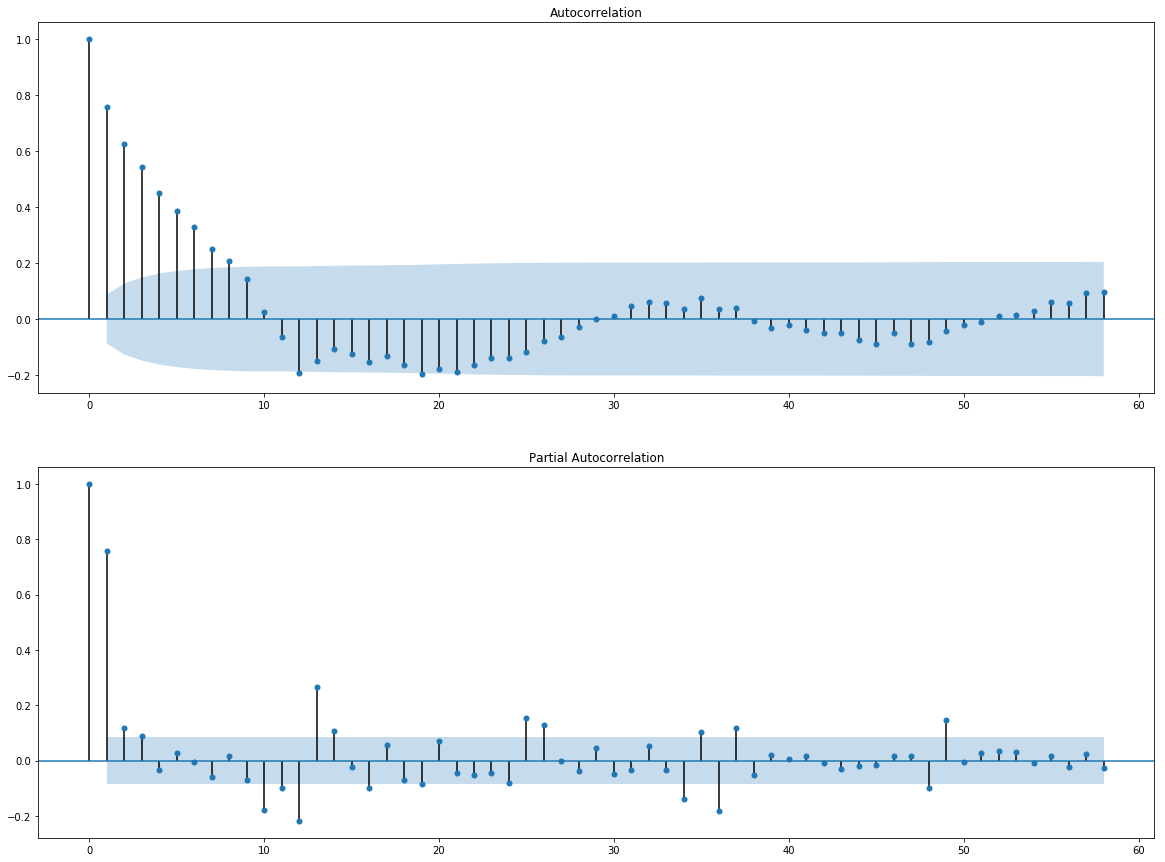

In [32]:
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df_train['value_diff'][12:].values.squeeze(), lags=58, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df_train['value_diff'][12:].values.squeeze(), lags=58, ax=ax);

Функцию подбора параметров модели можно позаимствовать из лекции. Границы интервалов поиска параметров ARIMA зададим исходя из коррелограмм, на которых явно прослеживается автокорреляция с лагом 1.

In [33]:
%%time
results = []
best_aic = float("inf")

ps = range(0, 3)
d=1
qs = range(0, 3)
Ps = range(0, 3)
D=1
Qs = range(0, 3)
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)

for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(df_train['value'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

wrong parameters: (0, 0, 0, 0)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Library/Frameworks/Python.frame

CPU times: user 3min 15s, sys: 16.4 s, total: 3min 32s
Wall time: 3min 17s


In [34]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters          aic
73  (2, 2, 0, 2)  2817.110096
75  (2, 2, 1, 1)  2817.603393
37  (1, 1, 0, 2)  2817.707481
19  (0, 2, 0, 2)  2817.992052
39  (1, 1, 1, 1)  2818.160530


Остатки лучшей модели:

Критерий Стьюдента: p=0.957711
Критерий Дики-Фуллера: p=0.000000


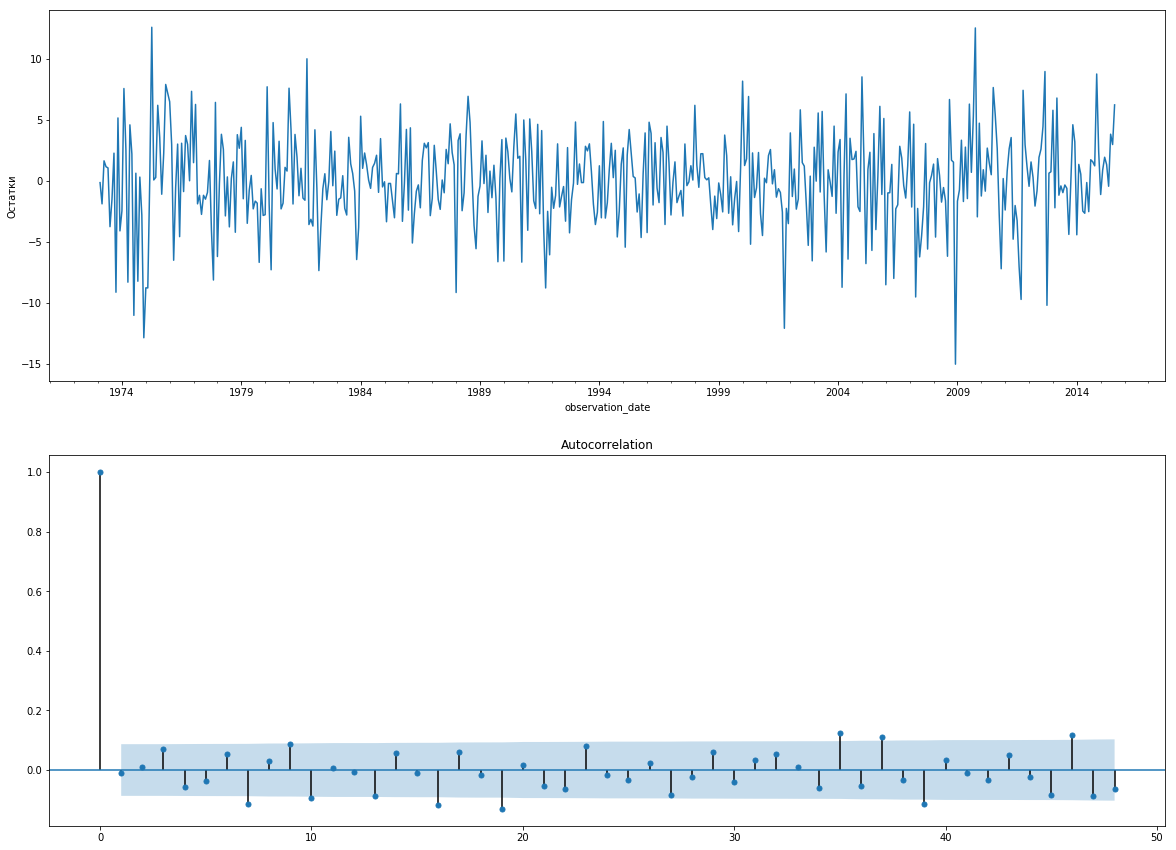

In [35]:
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Остатки')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Исходя из критерия Стьюдента, остатки смещены. Однако они стационарны (подтверждается критерием Дики-Фуллера и визуально) и неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой). Неидеальный случай, но жить можно.

Посмотрим, насколько хорошо модель описывает временной ряд.

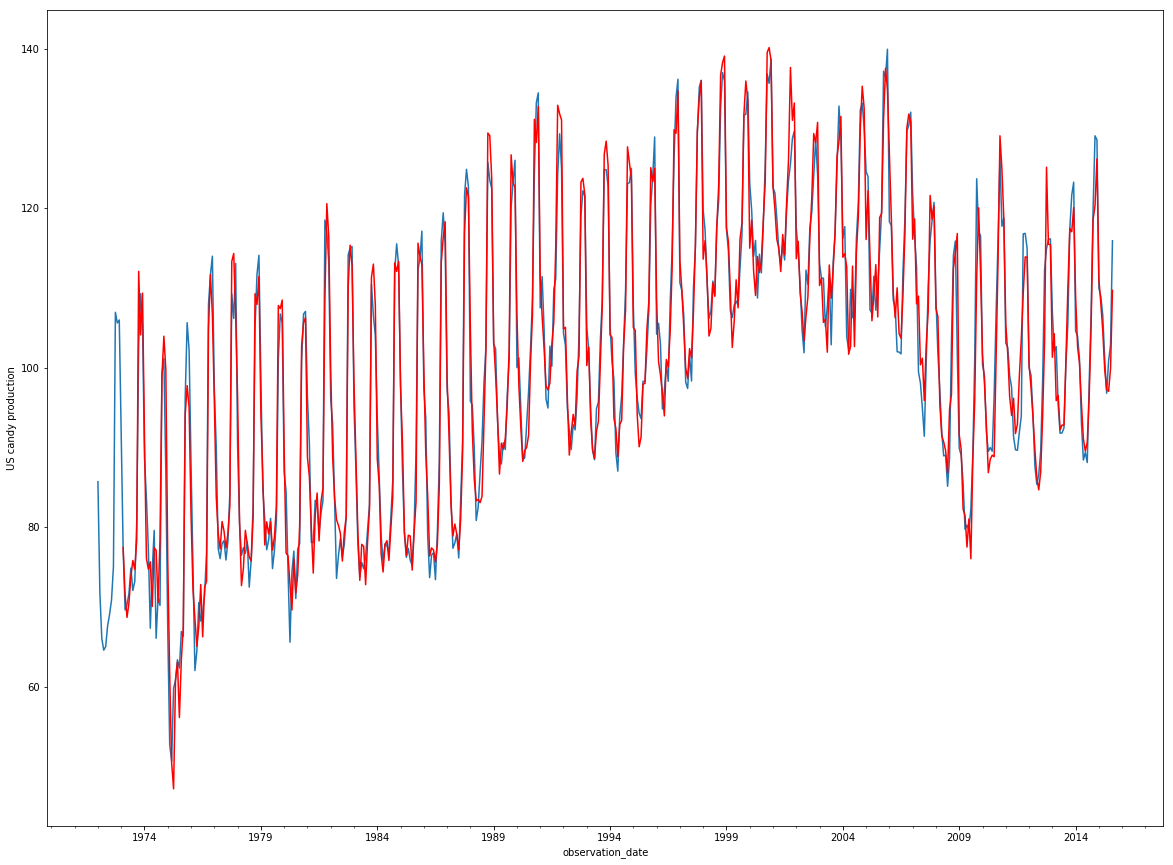

In [36]:
df_train['model'] = best_model.fittedvalues
df_train['value'].plot()
df_train['model'][13:].plot(color='r')
plt.ylabel('US candy production');

Видим, что модель очень хорошо подогналась под наши данные. Осталось проверить её на отложенной выборке.

# Facebook Prophet

Как уже упоминалось ранее, главное преимущество fbprophet - простота в использовании. Модель не требует настройки гиперпараметров.

In [37]:
fbmodel = fbprophet.Prophet(mcmc_samples=500)
fbmodel.fit(prophetdf_train)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


# XGBoost

Обучим модель из не более чем 1000 итераций. Валидируемся разбиением тренировочной выборки на 5 фолдов.

In [38]:
dtrain = xgb.DMatrix(XGBX_train, label=XGBy_train)

In [39]:
params = {
        'objective': 'reg:linear',
        'booster':'gblinear'
    }
rounds = 1000

In [40]:
cv = xgb.cv(params, dtrain, metrics = ('mae'), verbose_eval=False, nfold=5, 
            show_stdv=False, num_boost_round=rounds, seed=42)

In [41]:
bst = xgb.train(params, dtrain, num_boost_round=cv['test-mae-mean'].argmin())

Посмотрим MAE на кросс-валидации.

In [42]:
cv['test-mae-mean'].min()

7.3334496

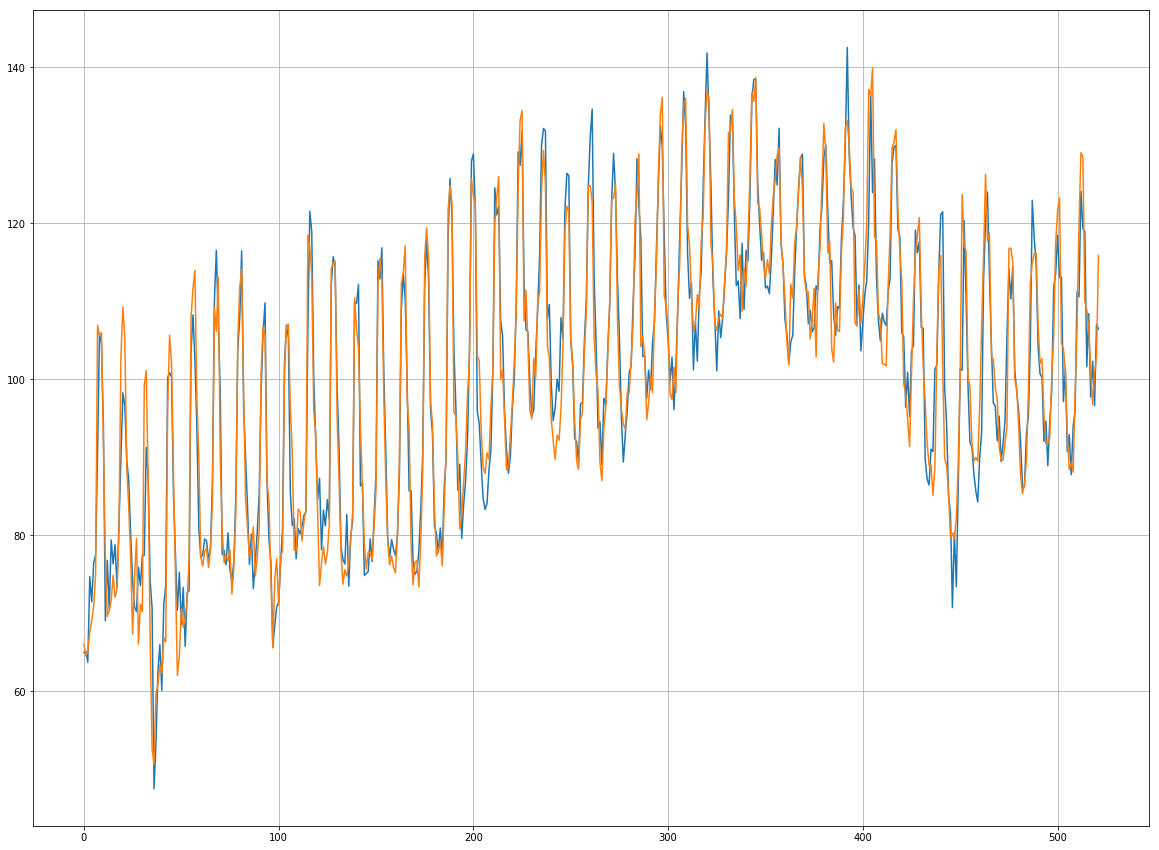

In [43]:
prediction_train = bst.predict(dtrain)
plt.plot(prediction_train)
plt.plot(XGBy_train.values)
plt.axis('tight')
plt.grid(True)

###  Прогноз на отложенной выборке

### SARIMAX

In [44]:
df_train["arima_model"] = best_model.fittedvalues
forecast = best_model.predict(start = df_train.shape[0], end = df_train.shape[0]+24)
forecast = df_train.arima_model.append(forecast).values
forecast = forecast[12:]

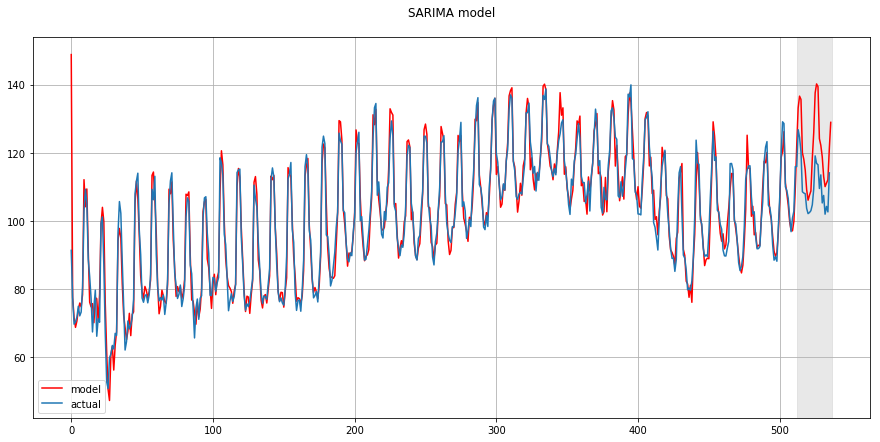

In [45]:
plt.figure(figsize=(15, 7))
plt.plot(forecast, color='r', label="model")

plt.title("SARIMA model\n")
plt.plot(df['value'].values[12:], label="actual")
plt.legend()
plt.axvspan(len(df['value'])-36, len(forecast), alpha=0.5, color='lightgrey')
plt.grid(True)

Как видим, модель обманулась скачком значений прямо на конце тренировочного периода и на тесте выдала немного завышенный прогноз.

In [46]:
mean_absolute_percentage_error(df['value'].values[-24:], forecast[-24:])

10.005215318239024

In [47]:
mean_absolute_error(df['value'].values[-24:], forecast[-24:])

11.045207292064617

MAPE 10.00%, MAE 11.04 на отложенной выборке - довольно неплохой результат.

### Facebook Prophet

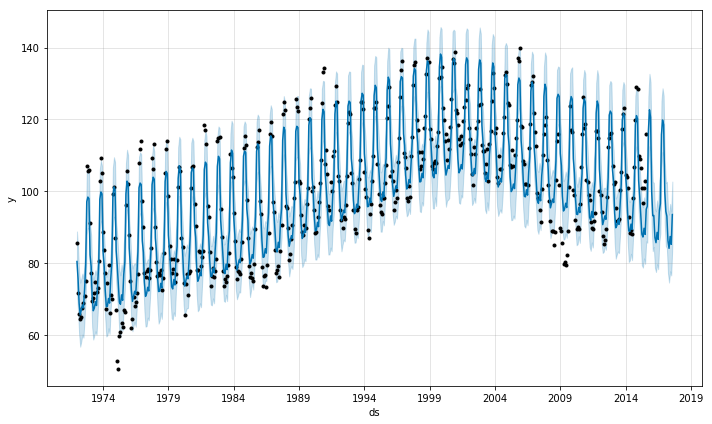

In [48]:
future = fbmodel.make_future_dataframe(periods=24, freq='M')
fbforecast = fbmodel.predict(future)
fbmodel.plot(fbforecast);

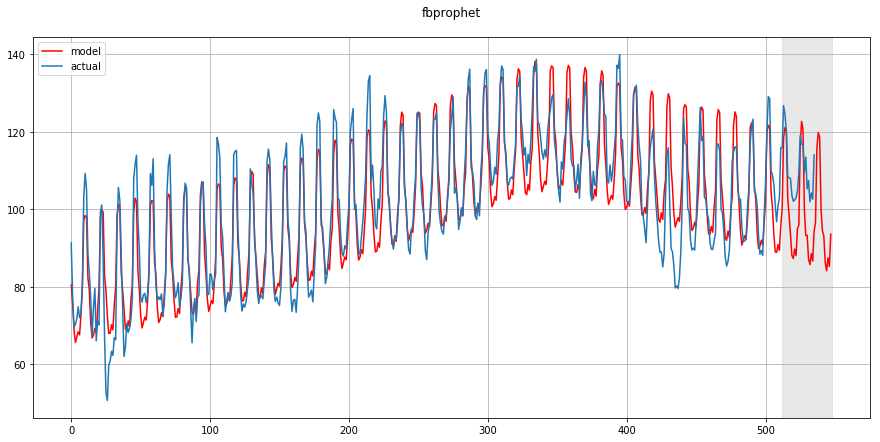

In [49]:
plt.figure(figsize=(15, 7))
plt.plot(fbforecast.yhat, color='r', label="model")

plt.title("fbprophet\n")
plt.plot(prophetdf['y'].values[12:], label="actual")
plt.legend()
plt.axvspan(len(df['value'])-36, len(fbforecast), alpha=0.5, color='lightgrey')
plt.grid(True)

In [50]:
mean_absolute_percentage_error(prophetdf.y[-24:], fbforecast.yhat[-24:])

11.558979817889202

In [51]:
mean_absolute_error(prophetdf.y[-24:], fbforecast.yhat[-24:])

12.468732498609782

Как итог, получаем MAPE в 11.55% и MAE в 12.46 на отложенной выборке. Как видно из графика, модель уловила основной тренд и годовую сезонность, но недостаточно резко реагирует на сильные колебания. Очень неплохой результат, учитывая, какими незначительными усилиями был получен прогноз, но другие модели позволяют достичь лучшего результата за счёт более тонкой настройки.

### XGBoost

In [52]:
dtest = xgb.DMatrix(XGBX_test)

In [53]:
prediction_test = bst.predict(dtest)

In [54]:
prediction = np.append(prediction_train, prediction_test)

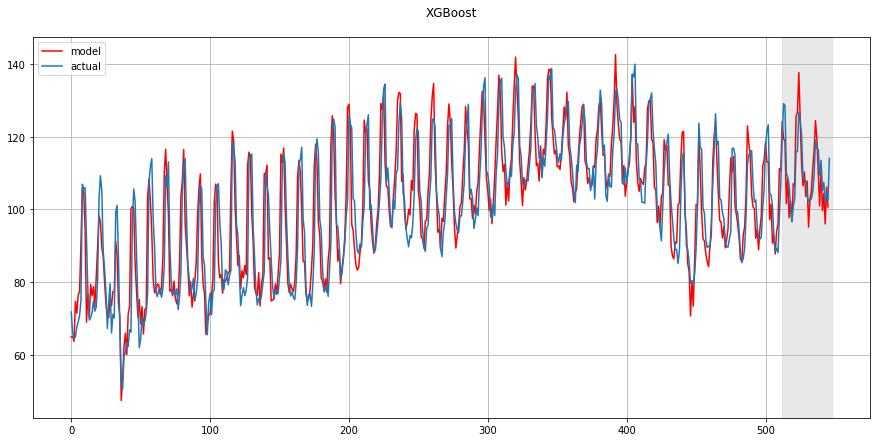

In [55]:
plt.figure(figsize=(15, 7))
plt.plot(prediction, color='r', label="model")
plt.title("XGBoost\n")
plt.plot(df['value'].values[1:], label="actual")
plt.legend()
plt.axvspan(len(df['value'])-36, len(fbforecast), alpha=0.5, color='lightgrey')
plt.grid(True)

In [56]:
mean_absolute_error(XGBy_test, prediction_test)

4.933508235677083

XGBoost наголову обогнал другие методы со вдвое меньшим значением MAE на отложенной выборке.

### Выводы 

В ходе выполнения работы было получено 3 модели, способные делать прогноз уровня производства конфет в США на 2 года вперёд. Как оказалось, довольно неплохой прогноз можно получить почти без усилий при помощи библотки Facebook Prophet, а вот ARIMA требует дополнительной предобработки данных и настройки гиперпараметров. Ну а XGBoost вновь продемонстрировал, за что его так любят на Kaggle.

В дальнейшем, прогнозы можно улучшить за счёт использования новой модели (например, LSTM RNN) или генерации других фич, используемых в обработке сигналов (например, Fast Fourier Transform).